# This file runs catboost step 1 (predicting conversion rate) and step 2 (revenue prediction for converted customers)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.multiclass import unique_labels

from catboost import CatBoostClassifier,  CatBoostRegressor, Pool, cv
from catboost.utils import eval_metric

from betacal import BetaCalibration
import shap

sys.path.append(str(Path('..').resolve()))
import revenue_model

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Load and preprocess train data

In [3]:
df_train = revenue_model.utils.load_data(extended=True, resampled=True)
df_train_all = revenue_model.preprocess(df_train)
df_train_all = revenue_model.add_features(df_train_all)

/home/carton/.pyenv/versions/s2ds/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/carton/work/s2ds/madecom/Made-2/revenue_model/external_features.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nothing_known['country_code_reverse'] = np.nan
/home/carton/work/s2ds/madecom/Made-2/revenue_model/external_features.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no

## Select features

In [4]:
features_step1 = ['is_converted','revenue', 'product_cart_adds', 'hits', 'time_on_site', 'pageviews', 
                'landing_product_type', 'product_list_impressions', 'product_page_views', 
                'landing_page_category', 'average_price_seen', 
                'productImpressionAvgPrice', 'productPageviewAvgPrice', 'productImpressionMaxPrice', 
                'productPageviewMaxPrice', 'visit_hour_of_day', 'dayweek', 'month', 'holiday', 
                'browser','geo_country_code', 'channel','device_category', 'operating_system', 
                'shop', 'is_promotional_period', 'eurostat_gdp_per_inhab_percEU27',
                'eurostat_ibuy_hh_goods', 'eurostat_population']
categorical_features_step1 =  [
                'landing_product_type', 
                'landing_page_category', 'holiday', 
                'browser','geo_country_code', 'channel','device_category', 'operating_system', 
                'shop', 'is_promotional_period']

In [5]:
df_train = df_train_all[features_step1]
df_train.head()

,is_converted,revenue,product_cart_adds,hits,time_on_site,pageviews,landing_product_type,product_list_impressions,product_page_views,landing_page_category,...,browser,geo_country_code,channel,device_category,operating_system,shop,is_promotional_period,eurostat_gdp_per_inhab_percEU27,eurostat_ibuy_hh_goods,eurostat_population
0,False,0.0,0,14,207,7,(homepage),2,1,Homepage,...,Chrome,gb,BRAND,mobile,Android,gb,False,718.0,54.0,1168.0
1,False,0.0,0,1,0,1,Downstairs Furniture,0,1,Product,...,Safari,gb,BRAND,mobile,iOS,gb,False,718.0,54.0,1168.0
2,False,0.0,0,8,100,4,Upholstery,80,2,Product,...,Safari (in-app),fr,SOCIAL_PAID,mobile,iOS,fr,False,199.0,30.0,12168.1
3,False,0.0,0,1,0,1,Soft Furnishings,0,1,Product,...,Chrome,fr,SEM_SHOPPING,desktop,Windows,fr,False,199.0,30.0,12168.1
4,False,0.0,0,1,0,1,Downstairs Furniture,0,1,Product,...,Safari,nl,SEM_SHOPPING,mobile,iOS,nl,False,110.0,45.0,410.0


In [6]:
X = df_train.drop(['is_converted', 'revenue'], axis=1)
y = df_train['is_converted']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

## Load test data

In [7]:
df_test_all = revenue_model.utils.load_data('test', extended=True, resampled=False, large=True)
df_test_all = revenue_model.preprocess(df_test_all)
df_test_all = revenue_model.add_features(df_test_all)

/home/carton/.pyenv/versions/s2ds/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/carton/work/s2ds/madecom/Made-2/revenue_model/external_features.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nothing_known['country_code_reverse'] = np.nan
/home/carton/work/s2ds/madecom/Made-2/revenue_model/external_features.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no

 ## Divide test dataset into calibration and test (while respecting time order)

In [8]:
unique_dates = df_test_all['date'].sort_values().dt.date.unique()
cal_dates = unique_dates[:len(unique_dates)//3]
m_cal = df_test_all['date'].isin(cal_dates)
m_test = ~m_cal

In [9]:
df_test_x = df_test_all[features_step1]
df_test_x = df_test_x.drop(['is_converted', 'revenue'], axis=1)
df_test_y = df_test_all[['is_converted']].astype(int)

In [10]:
X_cal = df_test_x.loc[m_cal]
X_test = df_test_x.loc[m_test]
y_cal = df_test_y.loc[m_cal]
y_test = df_test_y.loc[m_test]

# Step 1 - CatBoost classifier 

In [11]:
params = {
    'iterations': 400, 
    'eval_metric': 'F1', 
    'random_seed': 42, 
    'logging_level': 'Silent',
    'use_best_model': True, 
    'custom_loss':['Logloss', 'Precision', 'Recall'],
}

model1 = CatBoostClassifier(**params)


train_pool = Pool(X_train, y_train.astype(int), cat_features=categorical_features_step1)
validate_pool = Pool(X_val, y_val.astype(int), cat_features=categorical_features_step1)

model1.fit(
    train_pool,
    eval_set=validate_pool,
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
model1.get_best_score()

{'learn': {'Recall': 0.4560655545342538,
  'Logloss': 0.20533693846891635,
  'F1': 0.5929542189506338,
  'Precision': 0.8472605725911931},
 'validation': {'Recall': 0.43988109207541265,
  'Logloss': 0.2152488961230651,
  'F1': 0.5719664207580768,
  'Precision': 0.8210464605012457}}

Confusion matrix, without normalization
[[94856  1251]
 [ 7162  5621]]


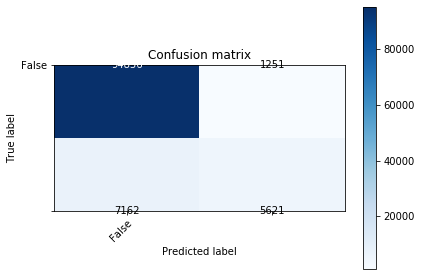

In [13]:
# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
predict_val = model1.predict(X_val)

plot_confusion_matrix(y_val, predict_val, classes = np.array([True, False]),
                      title='Confusion matrix', normalize=False)

# Beta calibration


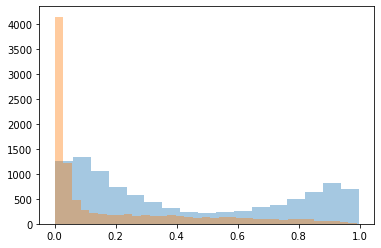

In [14]:
# Fit three-parameter beta calibration
betaCal = BetaCalibration(parameters="abm")

y_cal_pred = model1.predict_proba(X_cal)[:,1]
betaCal.fit(y_cal_pred.reshape(-1, 1), y_cal)

y_test_pred_prob = model1.predict_proba(X_test)[:,1]
y_test_pred_prob = betaCal.predict(y_test_pred_prob.reshape(-1, 1))
y_test_pred = y_test_pred_prob > 0.5

fig, ax = plt.subplots()
sns.distplot(model1.predict_proba(X_test)[y_test['is_converted'] == 1, 1], kde=False)
sns.distplot(y_test_pred_prob[y_test['is_converted'] == 1], kde=False)
plt.show()

## Test on test data

In [15]:
test_pool = Pool(X_test, y_test, cat_features=categorical_features_step1)
print('\nTarget on test data',int(np.sum(y_test_pred)),' positives vs ',int(np.sum(y_test)),' in reality')

# Accuracy Score on test dataset
accuracy_test = eval_metric(np.array(y_test), y_test_pred, 'Accuracy')
print('\naccuracy_score on test dataset : ', accuracy_test)

# Precision Score on test dataset
Precision_test = eval_metric(np.array(y_test), y_test_pred, 'Precision')
print('\nPrecision_score on test dataset : ', Precision_test)

# Recall Score on test dataset
Recall_test = eval_metric(np.array(y_test),y_test_pred, 'Recall')
print('\nRecall_score on test dataset : ', Recall_test)

# F1 Score on test dataset
F1_test = eval_metric(np.array(y_test),y_test_pred, 'F1')
print('\nF1_score on test dataset : ', F1_test)


Target on test data 2348  positives vs  10040  in reality

accuracy_score on test dataset :  [0.9889986317003364]

Precision_score on test dataset :  [0.6775979557069847]

Recall_score on test dataset :  [0.15846613545816732]

F1_score on test dataset :  [0.2568614788505005]


In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    826765
           1       0.68      0.16      0.26     10040

    accuracy                           0.99    836805
   macro avg       0.83      0.58      0.63    836805
weighted avg       0.99      0.99      0.99    836805



Confusion matrix, without normalization
[[826008    757]
 [  8449   1591]]


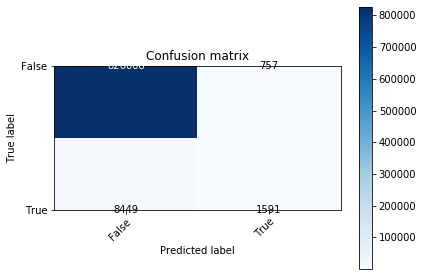

In [17]:
# Plot non-normalized confusion matrix
np.set_printoptions(precision=4)
plot_confusion_matrix(y_test, y_test_pred, classes = np.array([False, True]),
                      title='Confusion matrix', normalize=False)

## Plot precision-recall curve

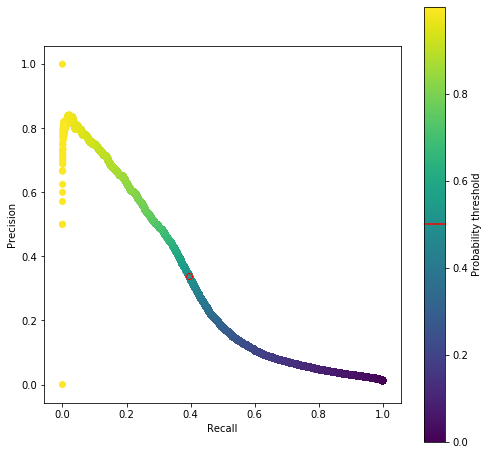

In [18]:
from sklearn.metrics import precision_recall_curve, auc
fig, ax = plt.subplots(figsize=[8,8])
ax.set_aspect(1)
y_test_pred = model1.predict(X_test)
y_test_pred_prob = model1.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
precision_best = precision_score(y_test, y_test_pred)
recall_best = recall_score(y_test, y_test_pred)
s = ax.scatter(recall, precision, c=np.concatenate([[0.], thresholds]))
ax.plot(recall_best, precision_best, marker='o', mfc='none', mec='r')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
cbar = plt.colorbar(s, ax=ax)
cbar.ax.set_ylabel("Probability threshold")
cbar.ax.axhline(0.5, color='r');

In [19]:
auc(recall, precision)

0.3054046165531882

## Estimate feature importance on test

In [20]:
feature_importances = model1.get_feature_importance(test_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

channel: 14.16982144536272
product_cart_adds: 11.732954335335217
shop: 9.364923758594987
geo_country_code: 8.926488533991876
browser: 8.562363894737631
time_on_site: 7.8356064461173185
hits: 6.734851327475326
device_category: 5.290517374275413
eurostat_ibuy_hh_goods: 4.481234593426921
operating_system: 4.472311001602646
product_page_views: 3.553083759593289
product_list_impressions: 2.4263406634704863
productPageviewMaxPrice: 1.7155687892827345
eurostat_gdp_per_inhab_percEU27: 1.4799400627643988
productPageviewAvgPrice: 1.4446766780735312
pageviews: 1.3083169329713675
productImpressionMaxPrice: 1.05221129010124
visit_hour_of_day: 1.0041695644414501
month: 0.775355529505109
productImpressionAvgPrice: 0.7684609146597038
landing_product_type: 0.7079595288635453
eurostat_population: 0.6911901824883818
landing_page_category: 0.5581935428304583
average_price_seen: 0.47168338880366717
dayweek: 0.289176490166589
is_promotional_period: 0.13956844298423376
holiday: 0.043031528079837636


In [21]:
shap.initjs()

shap_values = model1.get_feature_importance(test_pool, type='ShapValues')

In [22]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [23]:
# visualize prediction's explanation for a given sample point
shap.force_plot(expected_value, shap_values[6,:], X_test.iloc[6,:])

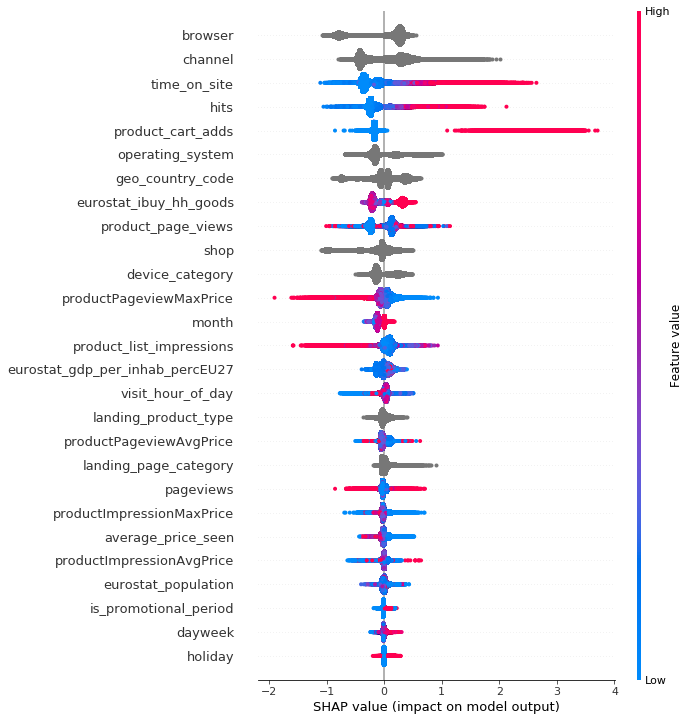

In [24]:
# average impact of a feature in model prediction
shap.summary_plot(shap_values, X_test, max_display = 30)

# Step 2 - CatBoost regression for revenue prediction
# Using only converted data 

In [25]:
features_step2 = ['is_converted','revenue', 'product_cart_adds', 'hits', 'time_on_site',  'pageviews',
                  'landing_product_type', 'product_page_views', 'product_list_impressions', 
                  'landing_page_category', 
                  'average_price_seen',  'productImpressionAvgPrice', 'productPageviewAvgPrice', 
                  'productImpressionMaxPrice', 'productPageviewMaxPrice',
                  'visit_hour_of_day', 'dayweek', 'month', 'holiday',
                  'browser','geo_country_code',
                   'channel','device_category', 'operating_system', 
                    'shop', 'is_promotional_period', 'eurostat_gdp_per_inhab_percEU27',
                   'eurostat_ibuy_hh_goods', 'eurostat_population']


categorical_features_step2 = [
                  'landing_product_type',
                  'landing_page_category', 
                   'holiday',
                  'browser','geo_country_code',
                   'channel','device_category', 'operating_system', 
                    'shop', 'is_promotional_period']

In [26]:
df_train_rev = df_train_all[features_step2]

In [27]:
df_train_rev = df_train_rev[df_train_rev.is_converted]

In [28]:
X_rev = df_train_rev.drop(['is_converted', 'revenue'], axis=1)
y_rev = df_train_rev['revenue']

In [29]:
# Add prob of conversion from step 1 as a feature of the train set
df_aux = df_train_all[features_step1]
prob_conv_train = model1.predict_proba(df_aux[df_aux.is_converted].drop(['is_converted', 'revenue'], axis=1))[:,1]
prob_conv_train = betaCal.predict(prob_conv_train.reshape([-1,1]))
X_rev['prob_of_conversion'] = prob_conv_train

## Prepare test set for step2 

In [30]:
# we need this extra step because we are using different sets of features in step 1 and 2 
df_aux = df_test_all[features_step1]
X_aux = df_aux.drop(['is_converted', 'revenue'], axis=1)
prob_conversion_test = model1.predict_proba(X_aux)[:,1] 
prob_conversion_test = betaCal.predict(prob_conversion_test.reshape([-1,1]))

In [31]:
df_test_rev_x = df_test_all[features_step2]
df_test_rev_y = df_test_all.revenue

In [32]:
df_test_rev_x_conv = df_test_rev_x[df_test_rev_x.is_converted]
df_test_rev_x_conv.shape

(15673, 29)

In [33]:
# Add prob of conversion from step 1 as a feature of the test set
df_test_rev_x_conv['prob_of_conversion'] = prob_conversion_test[df_test_rev_x.is_converted]

In [34]:
df_test_rev_y_conv = df_test_rev_x_conv.revenue
df_test_rev_x_conv = df_test_rev_x_conv.drop(['is_converted', 'revenue'], axis=1)

In [35]:
X_train_rev, X_val_rev, y_train_rev, y_val_rev = train_test_split(X_rev, y_rev, train_size=0.8, random_state=42)
X_test_rev = df_test_rev_x_conv
y_test_rev = df_test_rev_y_conv

## Run CatBoost regression model

In [36]:
params = {
    'iterations': 1000,
    'learning_rate': 0.3,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'random_seed': 22,
    'logging_level': 'Silent',
    'use_best_model': True,
    'custom_metric':['SMAPE', 'MAPE', 'MAE', 'R2'],
}

model2 = CatBoostRegressor(**params)

train_pool_rev = Pool(X_train_rev, y_train_rev.astype(int), cat_features=categorical_features_step2)
validate_pool_rev = Pool(X_val_rev, y_val_rev.astype(int), cat_features=categorical_features_step2)

model2.fit(
    train_pool_rev,
    eval_set=validate_pool_rev,
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
model2.get_best_score()

{'learn': {'MAE': 119.66685800964923,
  'MAPE': inf,
  'SMAPE': 59.90800876394415,
  'R2': 0.7124828819782176,
  'RMSE': 217.0651295662756},
 'validation': {'MAE': 147.84831251809877,
  'MAPE': inf,
  'SMAPE': 62.68523344140341,
  'R2': 0.34510386450742336,
  'RMSE': 297.75899246635794}}

## Test on test data

In [38]:
test_pool_rev = Pool(X_test_rev, y_test_rev, cat_features=categorical_features_step2)
predict_test_rev = model2.predict(X_test_rev)

mape = eval_metric(np.array(y_test_rev), predict_test_rev, 'MAPE') # it's in percentage !
print('\nMAPE on test dataset : ', mape)

mae = eval_metric(np.array(y_test_rev), predict_test_rev, 'MAE') 
print('\nMAE on test dataset : ', mae)

smape = eval_metric(np.array(y_test_rev), predict_test_rev, 'SMAPE') 
print('\nSMAPE on test dataset : ', smape)


MAPE on test dataset :  [1.6005759722267126]

MAE on test dataset :  [145.14165409520598]

SMAPE on test dataset :  [62.89344953720914]


## Estimate feature importance step 2 on test set

In [39]:
feature_importances_rev = model2.get_feature_importance(test_pool_rev)
feature_names_rev = X_train_rev.columns
for score, name in sorted(zip(feature_importances_rev, feature_names_rev), reverse=True):
    print('{}: {}'.format(name, score))

productPageviewAvgPrice: 19.612415813238794
productPageviewMaxPrice: 16.830802880390966
product_cart_adds: 11.684114613294108
channel: 7.142472625322868
average_price_seen: 5.817034788861128
prob_of_conversion: 4.498401666948521
time_on_site: 3.9596320516297796
visit_hour_of_day: 3.0356586748452865
shop: 2.8945952682147453
eurostat_population: 2.6902349683117834
product_list_impressions: 2.6245848787944706
pageviews: 2.382200434051872
device_category: 1.9661368708284628
hits: 1.9096462098112774
productImpressionAvgPrice: 1.8961268499957291
product_page_views: 1.5336982348266799
month: 1.3541325640234319
browser: 1.2319674693847198
eurostat_gdp_per_inhab_percEU27: 1.1824647211892962
productImpressionMaxPrice: 1.136456573056691
landing_product_type: 0.9868848242775139
operating_system: 0.8446873350579779
landing_page_category: 0.718599861558993
geo_country_code: 0.6968084426866972
is_promotional_period: 0.4989455564726938
dayweek: 0.4518465843199606
eurostat_ibuy_hh_goods: 0.419449238605

In [40]:
shap.initjs()
shap_values_rev = model2.get_feature_importance(test_pool_rev, type='ShapValues')

In [41]:
expected_value_rev = shap_values_rev[0,-1]
shap_values_rev = shap_values_rev[:,:-1]

In [42]:
shap.force_plot(expected_value_rev, shap_values_rev[121,:], X_test_rev.iloc[121,:])

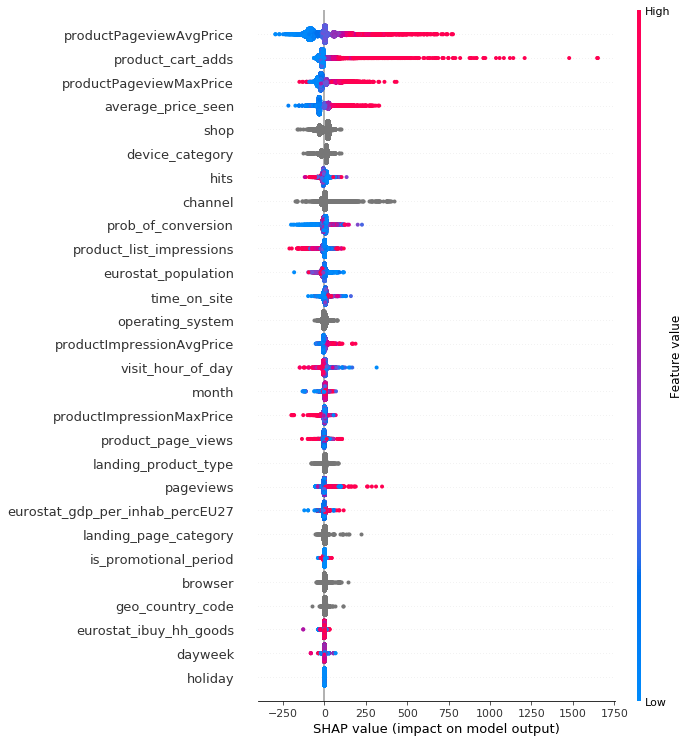

In [43]:
shap.summary_plot(shap_values_rev, X_test_rev, max_display = 30)

# Plots for single customer value model evaluation (all samples predicted to convert)

In [44]:
X_test_all = df_test_rev_x
y_test_all = df_test_rev_y

In [45]:
df_aux = df_test_all[features_step1]
X_aux = df_aux.drop(['is_converted', 'revenue'], axis=1)
prob_conversion_test_predconv = model1.predict_proba(X_aux)[:,1] 
prob_conversion_test_predconv = betaCal.predict(prob_conversion_test_predconv.reshape([-1,1]))

In [46]:
X_test_all['prob_of_conversion'] = prob_conversion_test_predconv

In [47]:
X_test_all = X_test_all.drop(['is_converted', 'revenue'], axis=1)

In [48]:
predict_test_all = model2.predict(X_test_all)

## Customer value plot for all test set with predicted probability > 0.5 (the ones we predict will convert)

In [49]:
y_test_all_small = y_test_all[prob_conversion_test_predconv > 0.5]
predict_test_all_small = predict_test_all[prob_conversion_test_predconv > 0.5]
prob_conversion_test_all_small = prob_conversion_test_predconv[prob_conversion_test_predconv > 0.5]

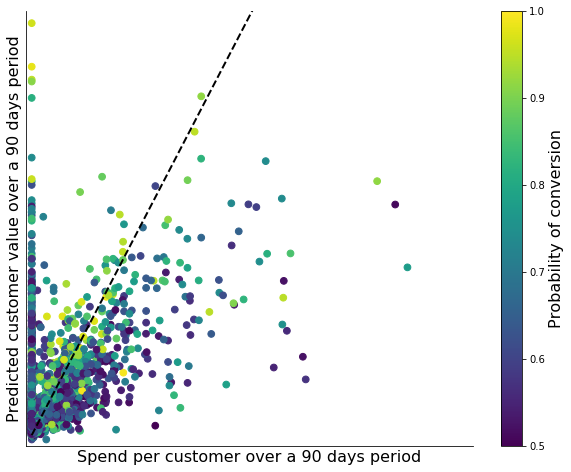

In [50]:
plt.figure(figsize=[10,8])
ax = plt.subplot(111)
plt.scatter(y_test_all_small, predict_test_all_small*prob_conversion_test_all_small, c=prob_conversion_test_all_small, s=45,vmin=0.5, vmax=1.)
plt.plot([0,4000], [0,4000], 'k--', lw=2)
plt.xlim([-50,4000])
plt.ylim([-50,2000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
plt.xlabel("Spend per customer over a 90 days period", fontsize=16)
plt.ylabel("Predicted customer value over a 90 days period", fontsize=16)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability of conversion', fontsize=16)
plt.show()

## Subselect the ones that actually converted

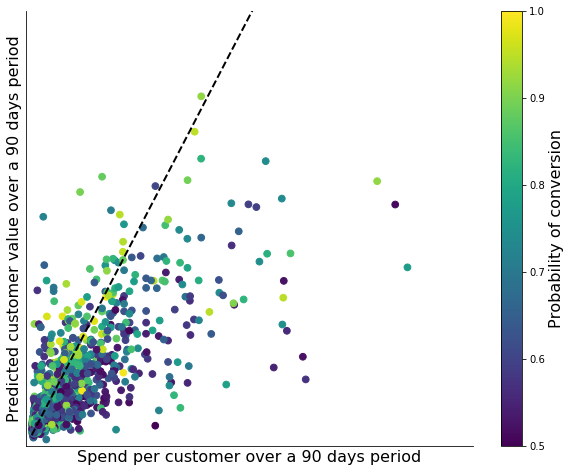

In [51]:
plt.figure(figsize=[10,8])
ax = plt.subplot(111)
plt.scatter(y_test_all_small[y_test_all_small>0], 
            predict_test_all_small[y_test_all_small>0]*prob_conversion_test_all_small[y_test_all_small>0],
            c=prob_conversion_test_all_small[y_test_all_small>0], s=45, vmin=0.5, vmax=1.)
plt.plot([0,4000], [0,4000], 'k--', lw=2)
plt.xlim([-50,4000])
plt.ylim([-50,2000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
plt.xlabel("Spend per customer over a 90 days period", fontsize=16)
plt.ylabel("Predicted customer value over a 90 days period", fontsize=16)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability of conversion', fontsize=16)
plt.show()

# Save results in a dataframe for further model evaluation

In [52]:
predict_conv_rate = model1.predict_proba(df_test_all[features_step1].drop(['is_converted', 'revenue'], axis=1))[:,1]
predict_conv_rate = betaCal.predict(predict_conv_rate.reshape([-1,1]))

df_test_a_rev = df_test_all[features_step2].drop(['is_converted', 'revenue'], axis=1)
df_test_a_rev['prob_of_conversion'] = predict_conv_rate
predict_rev =  model2.predict(df_test_a_rev)

cols = ['is_converted', 'revenue', 'shop', 'landing_product_type', 'medium', 'keyword']
df_test_out = df_test_all.loc[m_test,cols]
df_test_out['predicted_conversion'] = predict_conv_rate[m_test]
df_test_out['predicted_value'] = predict_conv_rate[m_test] * predict_rev[m_test]
df_test_out.to_pickle("./customer_value.pkl")